In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('/Users/younghun/Desktop/gitrepo/data/nlp-getting-started/')

# 데이터 로드

In [35]:
# 단순한 데이터 로드(메모리 절약 신경안쓸 때)
test = pd.read_csv('train.csv', encoding='utf-8')
# memory_usage()는 byte단위로 메모리 사용량 추출
# megabyte = 2의 20승 byte
print(f"Memory Usage: {test.memory_usage().sum()/1024**2 :.3f}MB")
test.head()

Memory Usage: 0.291MB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [36]:
# 칼럼별 메모리 사용량 나옴
test.memory_usage()

Index         128
id          60904
keyword     60904
location    60904
text        60904
target      60904
dtype: int64

In [37]:
# 수치형 dtype 값을 줄여줌으로써 메모리 낭비 방지
# dtype에 dict형태 인자로 넣어줄 수 있음
# 이 때, DataFrame의 칼럼별 dtype은 numpy array이기 때문에 np 붙여주기
df_train = pd.read_csv('train.csv', encoding='utf-8',
                      dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('test.csv', encoding='utf-8',
                     dtype={'id': np.int16, 'target': np.int8})

print(f"dtype 수정 후 메모리 사용량: {df_train.memory_usage().sum()/1024**2 : .3f}MB")

dtype 수정 후 메모리 사용량:  0.196MB


- dtype 수정 후 0.1 메가바이트가 줄어듦!

# Keyword and Location feature

## 결측치

In [18]:
# keyword and location 결측치가 Train, Test 데이터에서의 비율 살펴보기
train_rows = df_train.shape[0]
null_train_keyword = df_train.isnull().sum()[1]
null_train_location = df_train.isnull().sum()[2]

test_rows = df_test.shape[0]
null_test_keyword = df_test.isnull().sum()[1]
null_test_location = df_test.isnull().sum()[2]

null_train_keyword_ratio = (null_train_keyword/train_rows) * 100
null_train_location_ratio = (null_train_location/train_rows) * 100
null_test_keyword_ratio = (null_test_keyword/test_rows) * 100
null_test_location_ratio = (null_test_location/test_rows) * 100

print(f"Train 데이터 keyword 결측치 비율: {null_train_keyword_ratio:.2f}%")
print(f"Train 데이터 location 결측치 비율: {null_train_location_ratio:.2f}%")
print()
print(f"Test 데이터 keyword 결측치 비율: {null_test_keyword_ratio:.2f}%")
print(f"Test 데이터 location 결측치 비율: {null_test_location_ratio:.2f}%")

Train 데이터 keyword 결측치 비율: 0.80%
Train 데이터 location 결측치 비율: 33.27%

Test 데이터 keyword 결측치 비율: 0.80%
Test 데이터 location 결측치 비율: 33.86%


- Train, Test 각 데이터에서 결측치 비율이 거의 동일한 것으로 보아 **``결측치가 모두 같은 샘플에서 생성되었음을 추론할 수 있음!!``**

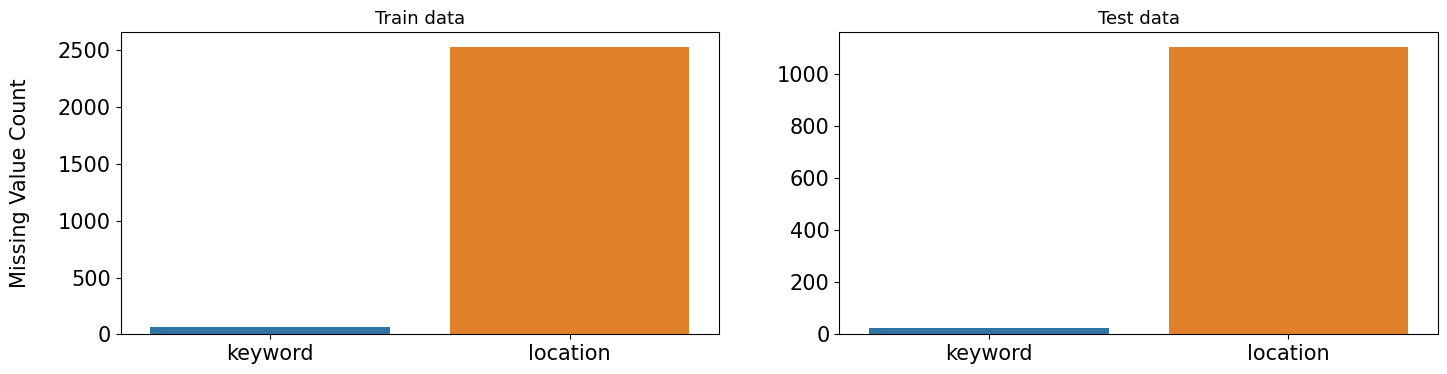

In [38]:
# Train, Test 데이터에서 각 결측치 비율 시각화
# 그리고 결측치를 특정 값들로 각각 대체
import matplotlib.pyplot as plt
import seaborn as sns

missing_cols = ['keyword', 'location']
# dpi는 그래프 크기 조절하는 인자
# inch * dpi = Pixel 단위공식
fig, axes = plt.subplots(figsize=(17,4), ncols=2, dpi=100)

sns.barplot(x=df_train[missing_cols].isnull().sum().index,
           y=df_train[missing_cols].isnull().sum().values,
           ax=axes[0])
sns.barplot(x=df_test[missing_cols].isnull().sum().index,
           y=df_test[missing_cols].isnull().sum().values,
           ax=axes[1])
# 각 그래프 축 외관 수정과 축이름 설정
axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20) #labelpad: 축과 축label 사이의 공간 지정
    # 축 외관수정하는 tick_params함수. axis에 'x'축인지 'y'축인지 설정하기
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

# 그래프 제목 설정
axes[0].set_title('Train data', fontsize=13)
axes[1].set_title('Test data', fontsize=13)
plt.show()

# 반복문 통해서 결측치 특정값으로 대체
dfs = [df_train, df_test]
for df in dfs:
    for col in missing_cols:
        # f string 활용해서 칼럼 이름 문자 포함하는 결측치 대체값 설정
        df[col] = df[col].fillna(f"no_{col}")

- **``Cardinality가 높다 = 중복도가 낮다``**

- location은 자동으로 생성되는 값들이 아닌 사용자들이 임의대로 만들어 내는 값들이기 때문에 지저분하고 유니크한 값들이 너무 많다. 따라서 적절한 feature는 아님

- keyword의 unique한 값 개수를 Train, Test 데이터에서 비교해보고 활용할 만한 feature인지 찾아보자. 

In [39]:
print(f"Number of unique values in keyword= {df_train['keyword'].nunique()} (Training)")
print(f"Number of unique values in keyword= {df_test['keyword'].nunique()} (Training)")
print()
print(f"Number of unique values in location= {df_train['location'].nunique()} (Training)")
print(f"Number of unique values in location= {df_test['location'].nunique()} (Training)")

Number of unique values in keyword= 222 (Training)
Number of unique values in keyword= 222 (Training)

Number of unique values in location= 3342 (Training)
Number of unique values in location= 1603 (Training)


- keyword는 unique한 값들이 Train, Test 데이터에서 개수가 **동일**하다
- 따라서 텍스트에 추가하던지 기타 방법으로 적절한 Feature로 사용 가능!

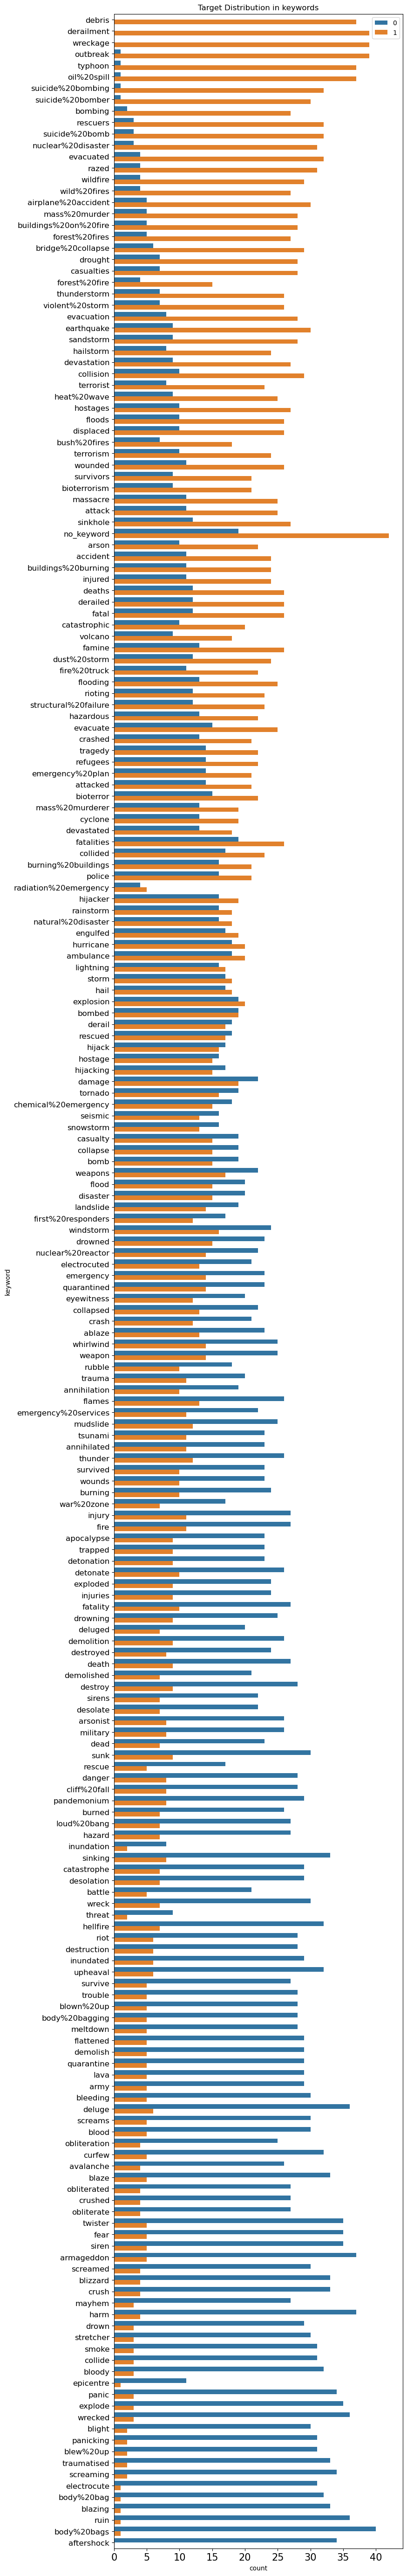

In [49]:
# Keyword 별로 Target 평균값 살펴보기
# 즉, Keyword 별로 disaster tweet인지 아닌지 관찰 가능

# group by 집계함수로 transform 함수도 있음, agg(dict)랑 동일!
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

# keyword별 disaster tweet 여부 빈도수 집계
sns.countplot(y=df_train.sort_values(by='target_mean',ascending=False)['keyword'],
           hue=df_train.sort_values(by='target_mean',ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
# loc=1='upper right'
plt.legend(loc=1)
plt.title('Target Distribution in keywords')
plt.show()

# target_mean 변수 삭제
df_train = df_train.drop('target_mean', axis=1)


# Meta features

- Disaster tweet은 non-disaster tweet보다 더 긴 단어를 사용해 공식적인 표현방법으로 쓰였을 것이고 더 적은 글자수(typo)를 가질 것이다. 이러한 분석을 위한 Meta feature들을 만들어 정의해보자.<br><br>

    - word_count: number of words in text
    - unique_word_count: number of unique words in text
    - stop_word_count:  number of stop words in text
    - url_count number: of urls in text
    - mean_word_length: average character count in words
    - char_count number: of characters in text
    - punctuation_count: number of punctuations(구두점) in text
    - hashtag_count: number of hashtags (#) in text
    - mention_count: number of mentions (@) in text